<a href="https://colab.research.google.com/github/tspn/Covid19Forecasting/blob/main/Downtrend_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==0.24

In [ ]:
IntervalDays = 5
MovingAverageWindow = IntervalDays
PredictionTargetDay = 1
CumulativeCases = "Cumulative_cases"
NewCases = "New_cases"
NormalizedCumulativeCases = "Normalized_cumulative_cases"
NormalizedNewCases = "Normalized_new_cases"
NormalizedMovingAvgCumulativeCases = "Normalized_MA_cumulative_cases"
NormalizedMovingAvgNewCases = "Normalized_MA_new_cases"

PredictionTargetDay = PredictionTargetDay - 1 

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MAPE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from statistics import mean
plt.rcParams['figure.figsize'] = [32, 12]

In [ ]:
df = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv', skipinitialspace=True)
df.set_index('Date_reported', inplace=True)
df = df[df["Country"].isin(df[df["Cumulative_cases"] > 10000]["Country"].unique())]
df = df[df["Country"].isin(df[df["New_cases"] > 400]["Country"].unique())]
df = df[~df["Country"].isin(df[df["New_cases"] < 0]["Country"].unique())]
# df = df.drop(["2021-01-20", "2021-01-21", "2021-01-22", "2021-01-23", "2021-01-24", "2021-01-25", "2021-01-26", "2021-01-27"])
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0
2020-01-04,AL,Albania,EURO,0,0,0,0
2020-01-05,AL,Albania,EURO,0,0,0,0
2020-01-06,AL,Albania,EURO,0,0,0,0
2020-01-07,AL,Albania,EURO,0,0,0,0
...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254


In [ ]:
cumulativeScaler = StandardScaler()
cumulativeScaler.fit(df[CumulativeCases].values.reshape(-1, 1))
df[NormalizedCumulativeCases] = cumulativeScaler.transform(df[CumulativeCases].values.reshape(-1, 1)).flatten()
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases
Date_reported,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.204273
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.204273
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.204273
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.204273
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.204273
...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.175864
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175728
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175501


In [ ]:
newCasesScaler = StandardScaler()
newCasesScaler.fit(df[NewCases].values.reshape(-1, 1))
df[NormalizedNewCases] = cumulativeScaler.transform(df[NewCases].values.reshape(-1, 1)).flatten()
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases
Date_reported,,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273
...,...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.175864,-0.204174
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175728,-0.204137
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175501,-0.204047


In [ ]:
for country in df["Country"].unique():
  df.loc[df["Country"] == country, [NormalizedMovingAvgCumulativeCases]] = df[df["Country"] == country][NormalizedCumulativeCases].rolling(10).mean().values 
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases
Date_reported,,,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.175864,-0.204174,-0.176954
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175728,-0.204137,-0.176697
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175501,-0.204047,-0.176458


In [ ]:
for country in df["Country"].unique():
  df.loc[df["Country"] == country, [NormalizedMovingAvgNewCases]] = df[df["Country"] == country][NormalizedNewCases].rolling(10).mean().values 
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases,Normalized_MA_new_cases
Date_reported,,,,,,,,,,,
2020-01-03,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN,NaN
2020-01-04,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN,NaN
2020-01-05,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN,NaN
2020-01-06,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN,NaN
2020-01-07,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.175864,-0.204174,-0.176954,-0.203989
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175728,-0.204137,-0.176697,-0.204016
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175501,-0.204047,-0.176458,-0.204034


In [ ]:
df = df.dropna()
df

,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Normalized_cumulative_cases,Normalized_new_cases,Normalized_MA_cumulative_cases,Normalized_MA_new_cases
Date_reported,,,,,,,,,,,
2020-01-12,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,-0.204273,-0.204273
2020-01-13,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,-0.204273,-0.204273
2020-01-14,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,-0.204273,-0.204273
2020-01-15,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,-0.204273,-0.204273
2020-01-16,AL,Albania,EURO,0,0,0,0,-0.204273,-0.204273,-0.204273,-0.204273
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,ZW,Zimbabwe,AFRO,117,33388,24,1217,-0.175864,-0.204174,-0.176954,-0.203989
2021-02-02,ZW,Zimbabwe,AFRO,160,33548,17,1234,-0.175728,-0.204137,-0.176697,-0.204016
2021-02-03,ZW,Zimbabwe,AFRO,266,33814,20,1254,-0.175501,-0.204047,-0.176458,-0.204034


In [ ]:
test_country = ["Brazil", "Thailand", "Malaysia", "Japan", "Republic of Korea"]
train_country = ['Albania','Algeria','Argentina','Armenia','Australia','Austria',
 'Azerbaijan','Bahrain','Bangladesh','Belarus','Belgium','Belize',
 'Bosnia and Herzegovina','Botswana','Bulgaria','Cabo Verde','Cameroon',
 'Canada','Chile','China','Colombia','Costa Rica','Côte d’Ivoire',
 'Croatia','Cyprus','Czechia','Democratic Republic of the Congo','Denmark',
 'Dominican Republic','Egypt','El Salvador','Estonia','Finland',
 'French Polynesia','Georgia','Germany','Ghana','Greece','Hungary','India',
 'Indonesia','Iran (Islamic Republic of)','Iraq','Ireland','Israel',
 'Jordan','Kazakhstan','Kenya','Kosovo[1]','Kuwait','Kyrgyzstan','Latvia',
 'Lebanon','Libya','Lithuania','Mexico','Montenegro','Morocco',
 'Mozambique','Myanmar','Netherlands','Nigeria','North Macedonia','Norway',
 'Oman','Pakistan','Panama','Peru','Philippines','Poland','Qatar',
 'Republic of Moldova','Romania','Russian Federation','Saudi Arabia',
 'Serbia','Singapore','Slovakia','Slovenia','South Africa','Spain',
 'Sri Lanka','Sweden','Switzerland','Tajikistan','The United Kingdom',
 'Tunisia','Turkey','Ukraine','United Arab Emirates',
 'United States of America','Uruguay','Uzbekistan',
 'Venezuela (Bolivarian Republic of)','Zimbabwe']

In [ ]:
def IsDowntrend(country, i):
  v = df[df["Country"] == country][NormalizedMovingAvgNewCases].values
  return v[i] > mean(v[i:i+IntervalDays])

In [ ]:
X = []
Y = []
for country in train_country:
  v = df[df["Country"] == country][NormalizedMovingAvgCumulativeCases].values
  for i in range(0, len(v) - IntervalDays-PredictionTargetDay):
    if IsDowntrend(country, i):
      X.append(v[i:i+IntervalDays])
      Y.append(v[i+IntervalDays+PredictionTargetDay])
  print(country)
X = np.array(X).reshape(-1, IntervalDays, 1)
Y = np.array(Y)

Albania
Algeria
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Belarus
Belgium
Belize
Bosnia and Herzegovina
Botswana
Bulgaria
Cabo Verde
Cameroon
Canada
Chile
China
Colombia
Costa Rica
Côte d’Ivoire
Croatia
Cyprus
Czechia
Democratic Republic of the Congo
Denmark
Dominican Republic
Egypt
El Salvador
Estonia
Finland
French Polynesia
Georgia
Germany
Ghana
Greece
Hungary
India
Indonesia
Iran (Islamic Republic of)
Iraq
Ireland
Israel
Jordan
Kazakhstan
Kenya
Kosovo[1]
Kuwait
Kyrgyzstan
Latvia
Lebanon
Libya
Lithuania
Mexico
Montenegro
Morocco
Mozambique
Myanmar
Netherlands
Nigeria
North Macedonia
Norway
Oman
Pakistan
Panama
Peru
Philippines
Poland
Qatar
Republic of Moldova
Romania
Russian Federation
Saudi Arabia
Serbia
Singapore
Slovakia
Slovenia
South Africa
Spain
Sri Lanka
Sweden
Switzerland
Tajikistan
The United Kingdom
Tunisia
Turkey
Ukraine
United Arab Emirates
United States of America
Uruguay
Uzbekistan
Venezuela (Bolivarian Republic of)
Zimbabwe


In [ ]:
i = Input(shape=(IntervalDays, 1))
x = LSTM(IntervalDays)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=["mape"])

In [ ]:
r = model.fit(X, Y, epochs=100, verbose=2, validation_split=0.3)

Epoch 1/100
287/287 - 3s - loss: 0.8008 - mape: 112.3058 - val_loss: 3.1670 - val_mape: 87.5470
Epoch 2/100
287/287 - 1s - loss: 0.5966 - mape: 31.6910 - val_loss: 2.7671 - val_mape: 16.1202
Epoch 3/100
287/287 - 1s - loss: 0.4255 - mape: 31.2587 - val_loss: 2.3962 - val_mape: 45.3986
Epoch 4/100
287/287 - 1s - loss: 0.2973 - mape: 35.6754 - val_loss: 2.0794 - val_mape: 34.7542
Epoch 5/100
287/287 - 1s - loss: 0.2281 - mape: 23.2535 - val_loss: 1.8843 - val_mape: 21.7529
Epoch 6/100
287/287 - 1s - loss: 0.1631 - mape: 12.9141 - val_loss: 1.6343 - val_mape: 13.4786
Epoch 7/100
287/287 - 1s - loss: 0.0979 - mape: 8.8495 - val_loss: 1.4708 - val_mape: 8.9069
Epoch 8/100
287/287 - 1s - loss: 0.0656 - mape: 4.3991 - val_loss: 1.3555 - val_mape: 4.7508
Epoch 9/100
287/287 - 1s - loss: 0.0451 - mape: 4.0751 - val_loss: 1.2661 - val_mape: 5.7116
Epoch 10/100
287/287 - 1s - loss: 0.0313 - mape: 4.0406 - val_loss: 1.1909 - val_mape: 4.1799
Epoch 11/100
287/287 - 1s - loss: 0.0215 - mape: 3.3129 

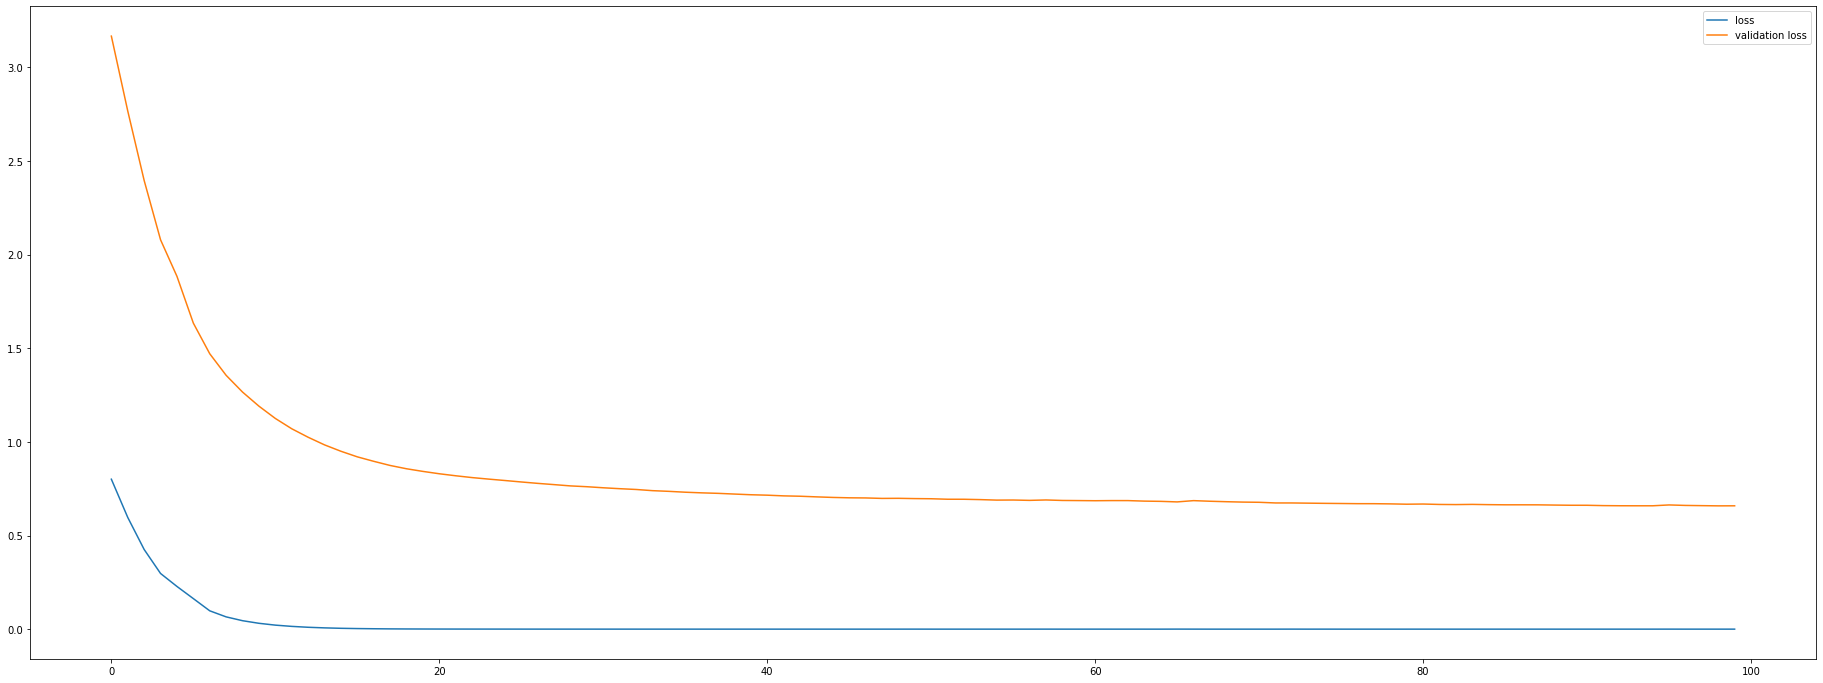

In [ ]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="validation loss")
plt.legend()

Brazil 0.007522907631240765
Thailand 5.00300786175901
Malaysia 4.880909572362809
Japan 1.1226659811263426
Republic of Korea 2.324176309898498


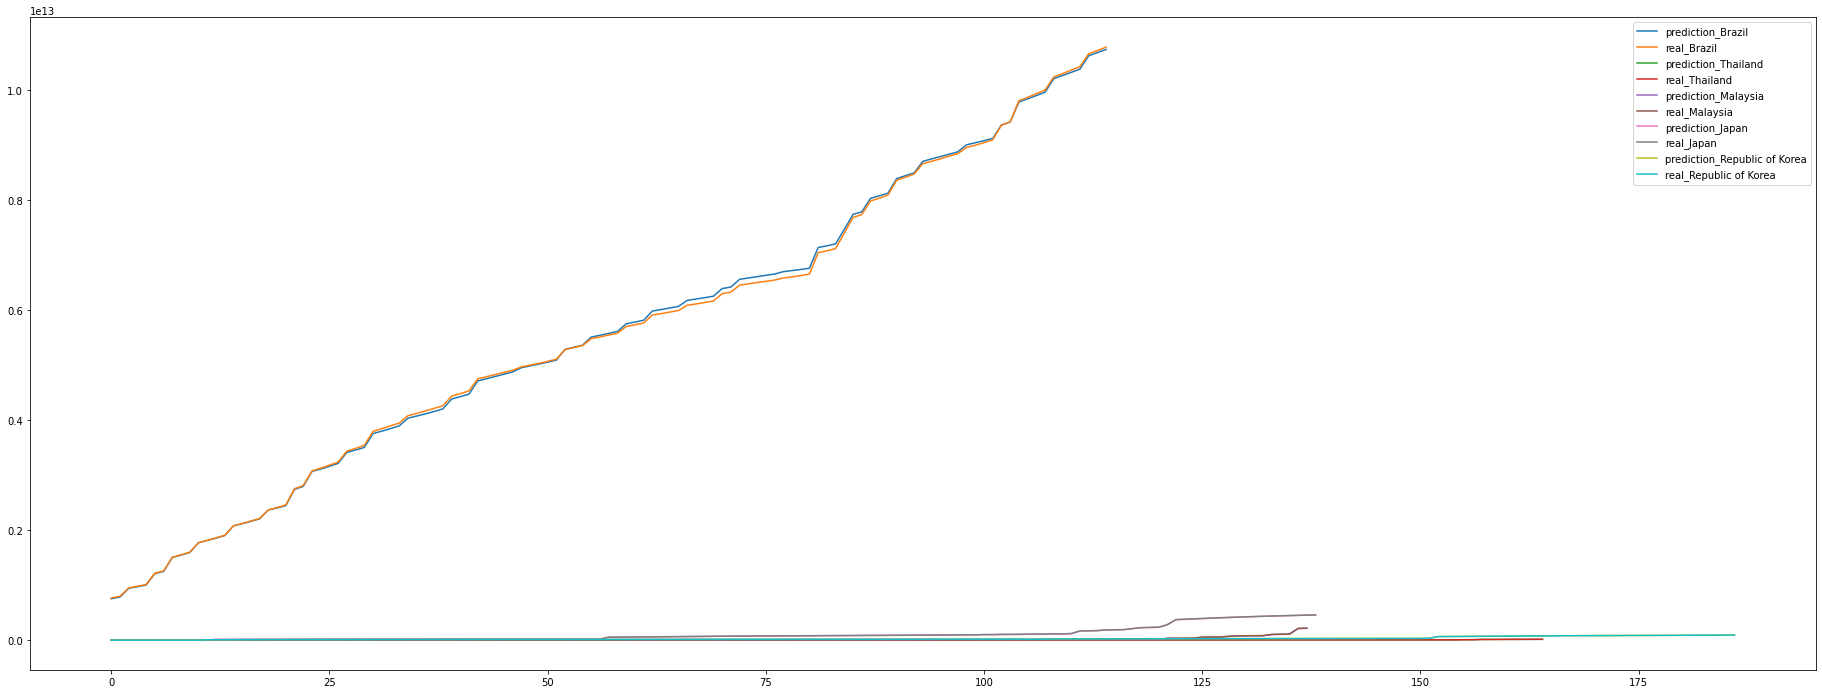

In [ ]:
def test(countryList, plot = False):
  for country in countryList:
    Xr = []
    Yr = []
    v = df[df["Country"] == country][NormalizedMovingAvgCumulativeCases].values
    for i in range(0, len(v) - IntervalDays - PredictionTargetDay):
      if IsDowntrend(country, i):
        Xr.append(v[i:i+IntervalDays])
        Yr.append(v[i+IntervalDays+PredictionTargetDay])
    Xr = np.array(Xr).reshape(-1, IntervalDays, 1)
    Yr = np.array(Yr)
    Yp = model.predict(Xr)
    Yr = cumulativeScaler.inverse_transform(Yr)
    Yp = cumulativeScaler.inverse_transform(Yp)
    print(country, mean_absolute_percentage_error(Yr, Yp))
    if plot:
      plt.plot(cumulativeScaler.inverse_transform(Yp), label='prediction_'+country)
      plt.plot(cumulativeScaler.inverse_transform(Yr), label='real_'+country)
      plt.legend()

test(test_country, True)

Thailand 5.00300786175901


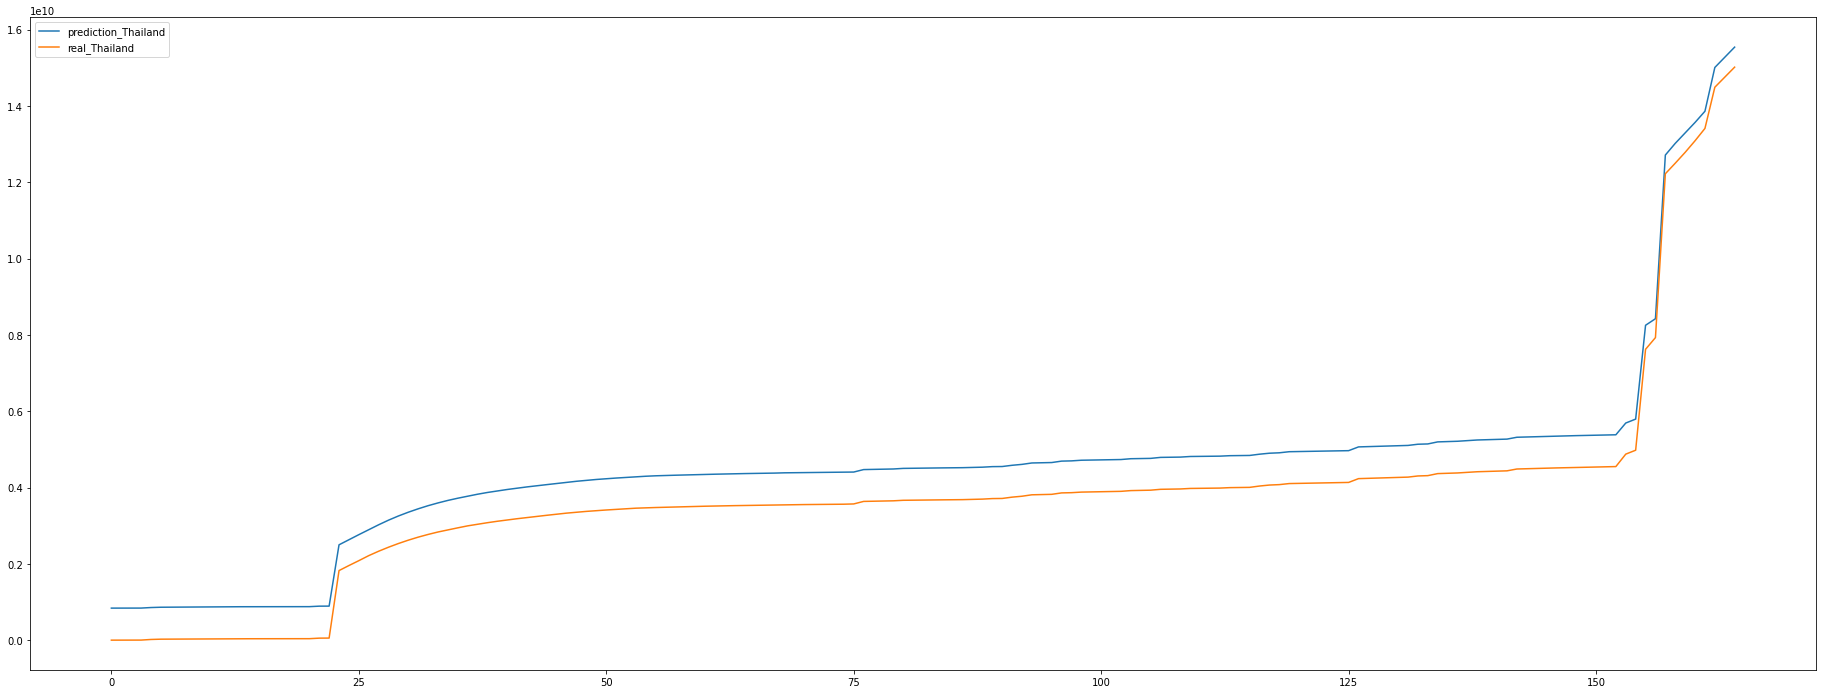

In [ ]:
test(["Thailand"], True)

Brazil 0.008972718334178342
Thailand 4.204670724747388
Malaysia 4.223138245881904
Japan 0.9553207771642495
Republic of Korea 1.6098539256706066


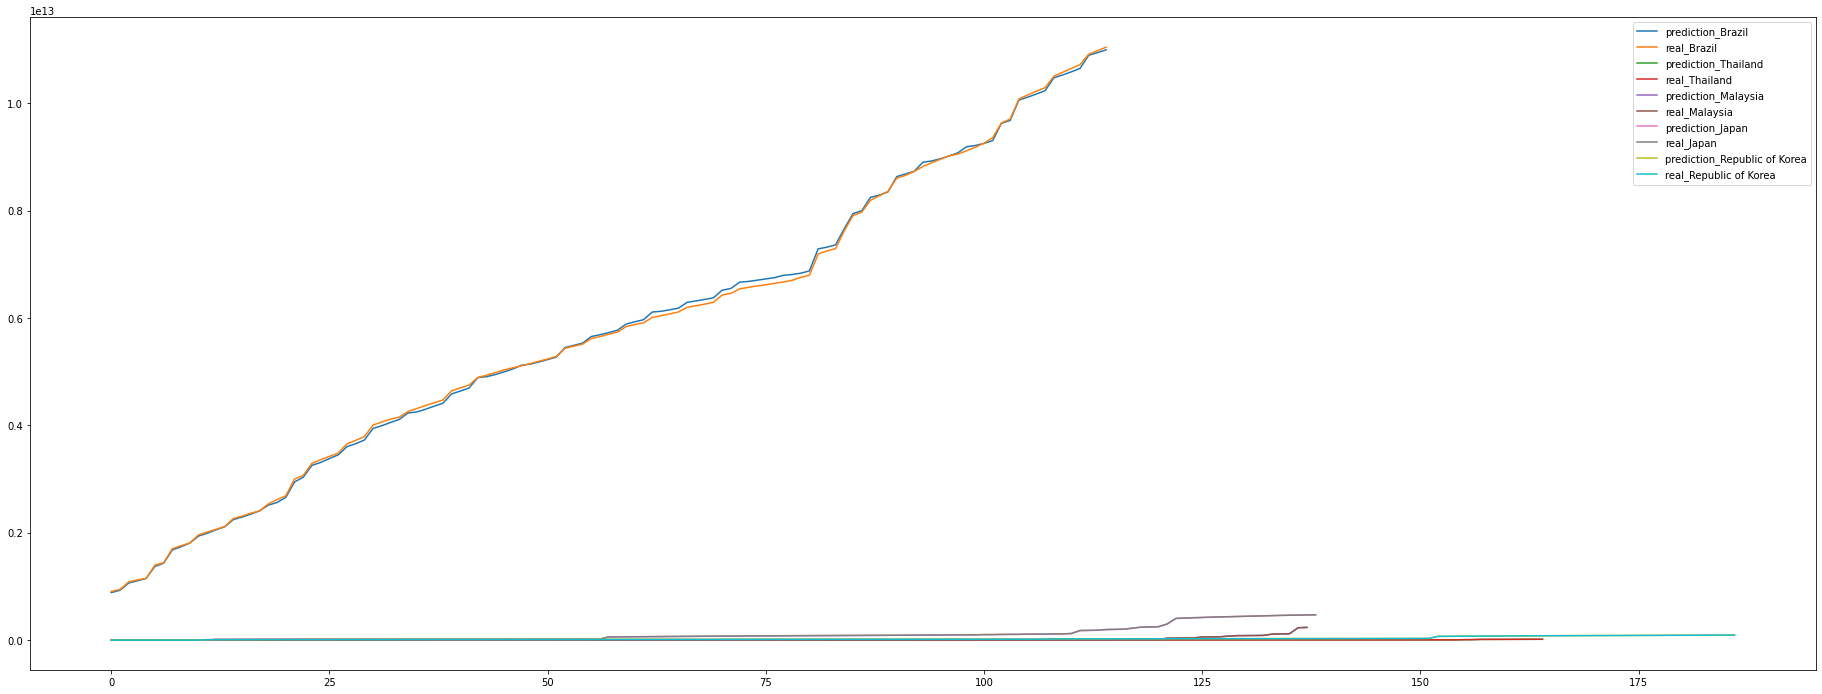

In [ ]:
def testNonMovingAvg(countryList, plot = False):
  for country in countryList:
    Xr = []
    Yr = []
    v = df[df["Country"] == country][NormalizedCumulativeCases].values
    for i in range(0, len(v) - IntervalDays - PredictionTargetDay):
      if IsDowntrend(country, i):
        Xr.append(v[i:i+IntervalDays])
        Yr.append(v[i+IntervalDays+PredictionTargetDay])
    Xr = np.array(Xr).reshape(-1, IntervalDays, 1)
    Yr = np.array(Yr)
    Yp = model.predict(Xr)
    Yr = cumulativeScaler.inverse_transform(Yr)
    Yp = cumulativeScaler.inverse_transform(Yp)
    print(country, mean_absolute_percentage_error(Yr, Yp))
    if plot:
      plt.plot(cumulativeScaler.inverse_transform(Yp), label='prediction_'+country)
      plt.plot(cumulativeScaler.inverse_transform(Yr), label='real_'+country)
      plt.legend()

testNonMovingAvg(test_country, True)